In [1]:
from nsga2.estimator import NSGAIIRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/lexicase_paper/d_airfoil.txt', sep=',')

# DEAP interface requires X and y to be numpy arrays, not pandas dataframes
X = df.drop('label', axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

estimator = NSGAIIRegressor(**{
    'pop_size'        : 80, 
    'max_gen'         : 20,
    'max_depth'       : 6,  # 8
    'max_size'        : 2**6, # 75
    'objectives'      : ['error', 'size'],
    'initialization'  : 'uniform',
    'pick_criteria'   : 'error', # error, MCDM
    'validation_size' : 0.33,
    'simplify'        : False,
    
    # Either you use smart variation (just 1 cx and 1 mutation)
    'smart_variation' : False,
    'warm_up'         : False,

    # Or you use mabs (4 mutations)
    'use_mab'         : False,
    'use_context'     : False,

    'simplification_method' : 'bottom_up',
    'simplification_tolerance' : 1e-0,
    'verbosity'       : 1,
    'survival'       : 'tournament'
}).fit(X_train, y_train)

gen	evals	best_size	best_error	n_simplifications	n_new_hashes	avg train error	avg train size	avg val error	avg val size	med train error	med train size	med val error	med val size	std train error	std train size	std val error	std val size	min train error	min train size	min val error	min val size	max train error	max train size	max val error	max val size
0  	80   	21       	-45.6909  	0                	0           	               	              	             	            	               	              	             	            	               	              	             	            	               	              	             	            	               	              	             	            
1  	80   	21       	-45.6903  	0                	0           	               	              	             	            	               	              	             	            	               	              	             	            	               	              	             	            	  

In [2]:
# Should not give erros even without mabs
pd.DataFrame(estimator.variator.mab.pull_history).iloc[:10]

,t,arm,reward,update,delta_error,gen
0,0,subtree,1.0,0,"[inf, 59.0]",1
1,1,insert,1.0,0,"[inf, 17.0]",1
2,2,insert,0.0,0,"[-367.3795727107273, 2.0]",1
3,3,insert,1.0,0,"[1224.5959671596245, -8.0]",1
4,4,cx,1.0,0,"[28.110040724259306, 1.0]",1
5,5,delete,0.0,0,"[-180.50295728544734, 11.0]",1
6,6,insert,0.0,0,"[-0.0005820351210061858, -0.0]",1
7,7,cx,0.0,0,"[-14992.221963385233, 5.0]",1
8,8,subtree,1.0,0,"[40.98249988799034, -0.0]",1
9,9,subtree,1.0,0,"[inf, -0.0]",1


In [3]:
pd.DataFrame(estimator.variator.mab.pull_history)['arm'].value_counts().sort_values()

insert     279
cx         287
point      316
subtree    318
delete     320
Name: arm, dtype: int64

In [4]:
pd.DataFrame(estimator.variator.mab.pull_history
             ).groupby('arm')['reward'].value_counts(normalize=True).sort_values()

arm      reward
subtree  0.0       0.166667
delete   0.0       0.190625
subtree  0.5       0.191824
delete   0.5       0.203125
point    0.0       0.224684
insert   0.0       0.232975
point    0.5       0.234177
cx       0.0       0.240418
insert   0.5       0.268817
cx       0.5       0.358885
         1.0       0.400697
insert   1.0       0.498208
point    1.0       0.541139
delete   1.0       0.606250
subtree  1.0       0.641509
Name: reward, dtype: float64

statistics (without nans and infs)
delta error
variation
cx          0.000000
delete      1.303344
insert      0.000000
point       0.064587
subtree    15.409332
Name: delta error, dtype: float64


/home/galdeia/miniconda3/envs/hashing-experiments/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/galdeia/miniconda3/envs/hashing-experiments/lib/python3.12/site-packages/matplotlib/cbook.py:1267: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/galdeia/miniconda3/envs/hashing-experiments/lib/python3.12/site-packages/matplotlib/cbook.py:1274: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/galdeia/miniconda3/envs/hashing-experiments/lib/python3.12/site-packages/matplotlib/cbook.py:1283: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


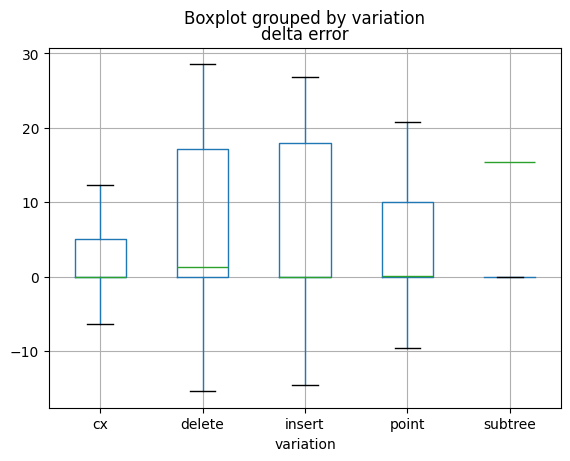

----------------------------------------
delta size
variation
cx         0.0
delete    -1.0
insert     1.0
point      0.0
subtree    2.0
Name: delta size, dtype: float64


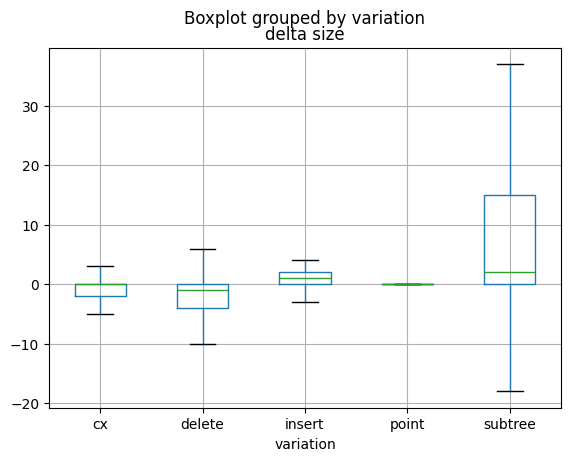

----------------------------------------
euclid dist prediction
variation
cx          0.939286
delete     45.536516
insert      7.679004
point      32.112732
subtree    24.998027
Name: euclid dist prediction, dtype: float64


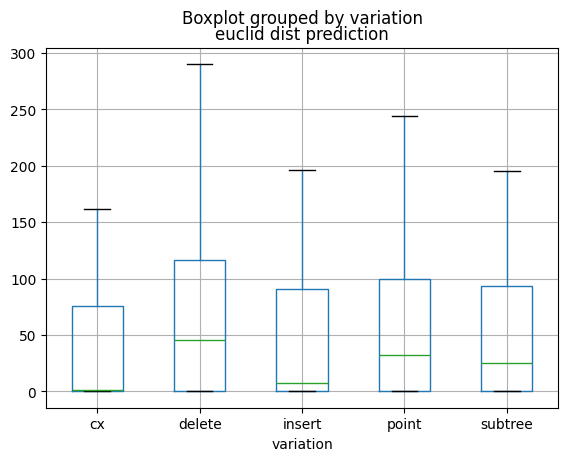

----------------------------------------


In [5]:
import matplotlib.pyplot as plt

variation_log = pd.DataFrame(estimator.variator.log)

print("statistics (without nans and infs)")
for col in ['delta error', 'delta size', 'euclid dist prediction']:
    print(col)
    print(variation_log
            .groupby('variation')[col]
            # .apply (lambda c: np.nanmean(c.replace([np.inf, -np.inf], np.nan).dropna()) )
            .apply (lambda c: np.nanmedian(c) )
            # .sort_values()
    )

    variation_log.boxplot(column=col, by='variation', showfliers=False)
    plt.show()
    
    print('-'*40)

,gen,variation,euclid dist prediction,delta error,delta size
0,1,subtree,NaN,inf,59.0
1,1,insert,NaN,inf,17.0
2,1,insert,442.119086,-367.379573,2.0
3,1,insert,954.279547,1224.595967,-8.0
4,1,cx,405.176522,28.110041,1.0
...,...,...,...,...,...
1515,19,point,28.619979,-1.584737,1.0
1516,19,point,69.881351,6.169978,-0.0
1517,19,point,27.755680,-1.593484,2.0
1518,19,subtree,81.886658,8.910055,14.0


subtree


/tmp/ipykernel_146954/900576179.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data[col] > 2e+1] = np.nan


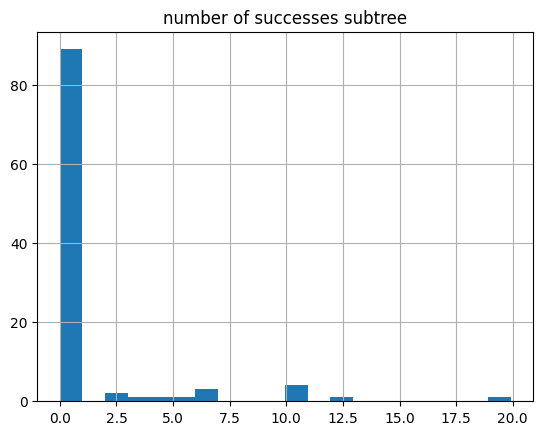

insert


/tmp/ipykernel_146954/900576179.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data[col] > 2e+1] = np.nan


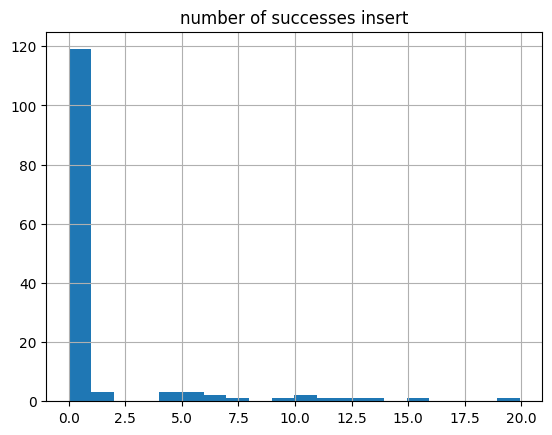

cx


/tmp/ipykernel_146954/900576179.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data[col] > 2e+1] = np.nan


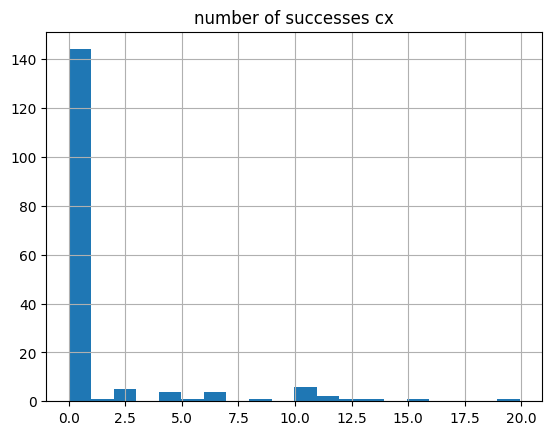

delete


/tmp/ipykernel_146954/900576179.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data[col] > 2e+1] = np.nan


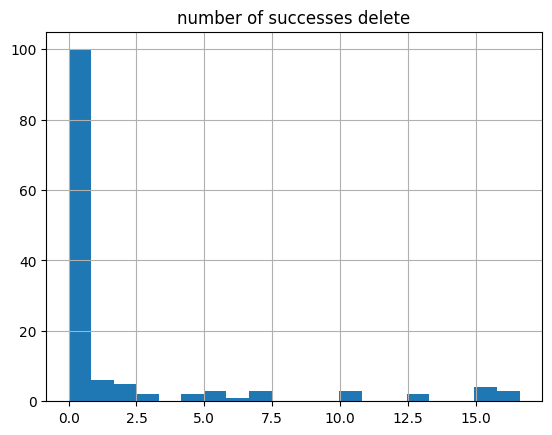

point


/tmp/ipykernel_146954/900576179.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data[col] > 2e+1] = np.nan


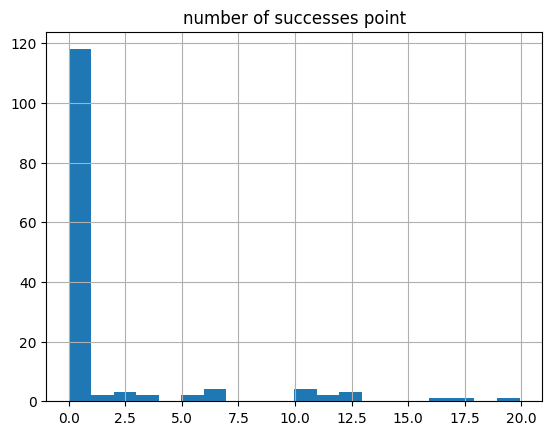

In [6]:
variation_log = pd.DataFrame(estimator.variator.log)

col = 'euclid dist prediction'
    
display(variation_log)
for mut in variation_log['variation'].unique():
    print(mut)

    data = variation_log[variation_log['variation']==mut]
    
    data[data[col] > 2e+1] = np.nan

    data = data.dropna()
    data['positive'] = data['delta error'] < -1e-6
    data.hist(column=col, bins=20)
    plt.title(f"number of successes {mut}")
    plt.show()

In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

model      = str(estimator.best_estimator_).replace("ARG", "x_")
size       = len(estimator.best_estimator_)
complexity = size
depth      = estimator.best_estimator_.height

print(model)
print(size)
print(complexity)
print(depth)

for metric, fn, (data_X, data_y) in [
    ('train_r2',  r2_score, (X_train, y_train)),
    ('test_r2',   r2_score, (X_test,  y_test )),
    ('train_mse', mse,      (X_train, y_train)),
    ('test_mse',  mse,      (X_test,  y_test )),
]:
    score = np.nan
    try:
        score = fn(estimator.predict(data_X), data_y)
        print(f"{metric} : {score}")
    except ValueError:
        print(f"(Failed to calculate {metric}")

for ind in estimator.archive_:
    print(ind.fitness, ind)

maximum(subtract(multiply(multiply(sqrt(maximum(minimum(tan(x_4), log(x_0)), minimum(minimum(x_4, x_1), square(x_4)))), x_0), -0.020263781169432945), -129.29133884769243), x_3)
21
21
8
train_r2 : -0.24273627859542324
test_r2 : -0.10048530432461855
train_mse : 26.332280723422294
test_mse : 24.08183697633042
(25.5431447714985, 21.0) maximum(subtract(multiply(multiply(sqrt(maximum(minimum(tan(ARG4), log(ARG0)), minimum(minimum(ARG4, ARG1), square(ARG4)))), ARG0), -0.020263781169432945), -129.29133884769243), ARG3)
(27.141154430052886, 14.0) maximum(subtract(multiply(multiply(log1p(multiply(tan(ARG4), sqrtabs(ARG0))), ARG0), -0.002936128679308248), -127.81044193335664), ARG3)


In [8]:
if False:
    print( len(list(estimator.simplifier.pop_hash.keys())) )

    n_keys =  len(list(estimator.simplifier.pop_hash.keys()))

    for key in list(estimator.simplifier.pop_hash.keys())[:n_keys]:
        print(key)
        for ind in estimator.simplifier.pop_hash[key]:
            print(" -", ind)

In [9]:
if True:
    print( len(list(estimator.variator.variator_.pop_hash.keys())) )

    n_keys =  len(list(estimator.variator.variator_.pop_hash.keys()))

    for key in list(estimator.variator.variator_.pop_hash.keys())[:n_keys]:
        print(key)
        for ind in estimator.variator.variator_.pop_hash[key]:
            print(" -", ind)

AttributeError: 'Variator' object has no attribute 'variator_'

In [ ]:
display(df.describe())

A = np.maximum(df['x0'], df['x4']+29.657).values
B = df['x4'].values

print(np.std(A) * (A - np.mean(A))[:5])
print(np.std(B) * (B - np.mean(B))[:5])